In [175]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import pyspark as spark

#read contents of csv into variables
datacenters = pd.read_csv("../data/datacenters.csv")
demand = pd.read_csv("../data/demand.csv")
selling_prices = pd.read_csv("../data/selling_prices.csv")
servers = pd.read_csv("../data/servers.csv")

# print(datacenters)
# print(demand)
# print(selling_prices)
# print(servers)

# First look at demand changes

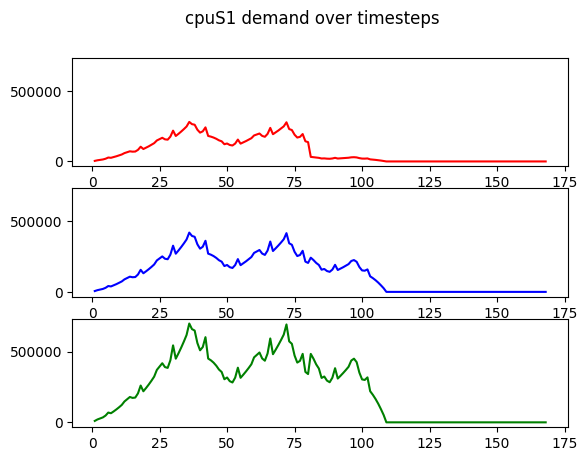

In [176]:
laten_sens_high = demand.loc[demand["latency_sensitivity"] == "high"]
laten_sens_med = demand.loc[demand["latency_sensitivity"] == "medium"]
laten_sens_low = demand.loc[demand["latency_sensitivity"] == "low"]

laten_sens_high_np = laten_sens_high.to_numpy()
laten_sens_med_np = laten_sens_med.to_numpy()
laten_sens_low_np = laten_sens_low.to_numpy()

#print(laten_sens_high_np)
fig, axs = plt.subplots(3, sharey=True)
fig.suptitle("cpuS1 demand over timesteps")
axs[0].plot(laten_sens_high_np[:, 0], laten_sens_high_np[:, 2], color="r")
axs[1].plot(laten_sens_med_np[:, 0], laten_sens_med_np[:, 2], color="b")
axs[2].plot(laten_sens_low_np[:, 0], laten_sens_low_np[:, 2], color="g")

# print(laten_sens_high)
# print(laten_sens_low)
# print(laten_sens_low)


In [207]:
servergen_maintenance_dict = {}
servergen_totalcost_dict = {}
servergen_profit_dict = {}
for i in servers["server_generation"]:
    servergen_maintenance_dict[i] = []
    servergen_totalcost_dict[i] = []
    servergen_profit_dict[i] = []

In [209]:
for i in servergen_maintenance_dict.keys():
    #calc maintenance cost over different timesteps using maintenance equation
    timestep_array = np.arange(1,96,1)
    maintenance_fee = servers[servers["server_generation"] == i]["average_maintenance_fee"].iloc[0]
    ts_array = 1.5 * timestep_array
    timestep_array = (1+ ts_array/96 * np.log2(ts_array/96)) * maintenance_fee
    timestep_array
    servergen_maintenance_dict[i] = timestep_array

    #calc totalcost
    servergen_energycost = servers[servers["server_generation"] == i]["energy_consumption"].iloc[0]
    servergen_totalcost_dict[i] = servergen_energycost + timestep_array

    #calc generated profit for that servergen
    server_capacity = servers[servers["server_generation"] == i]["capacity"].iloc[0]
    selling_price = selling_prices[selling_prices["server_generation"] == i]["selling_price"].mean()
    mean_revenue = np.full((95),selling_price*server_capacity)
    servergen_profit_dict[i] = mean_revenue

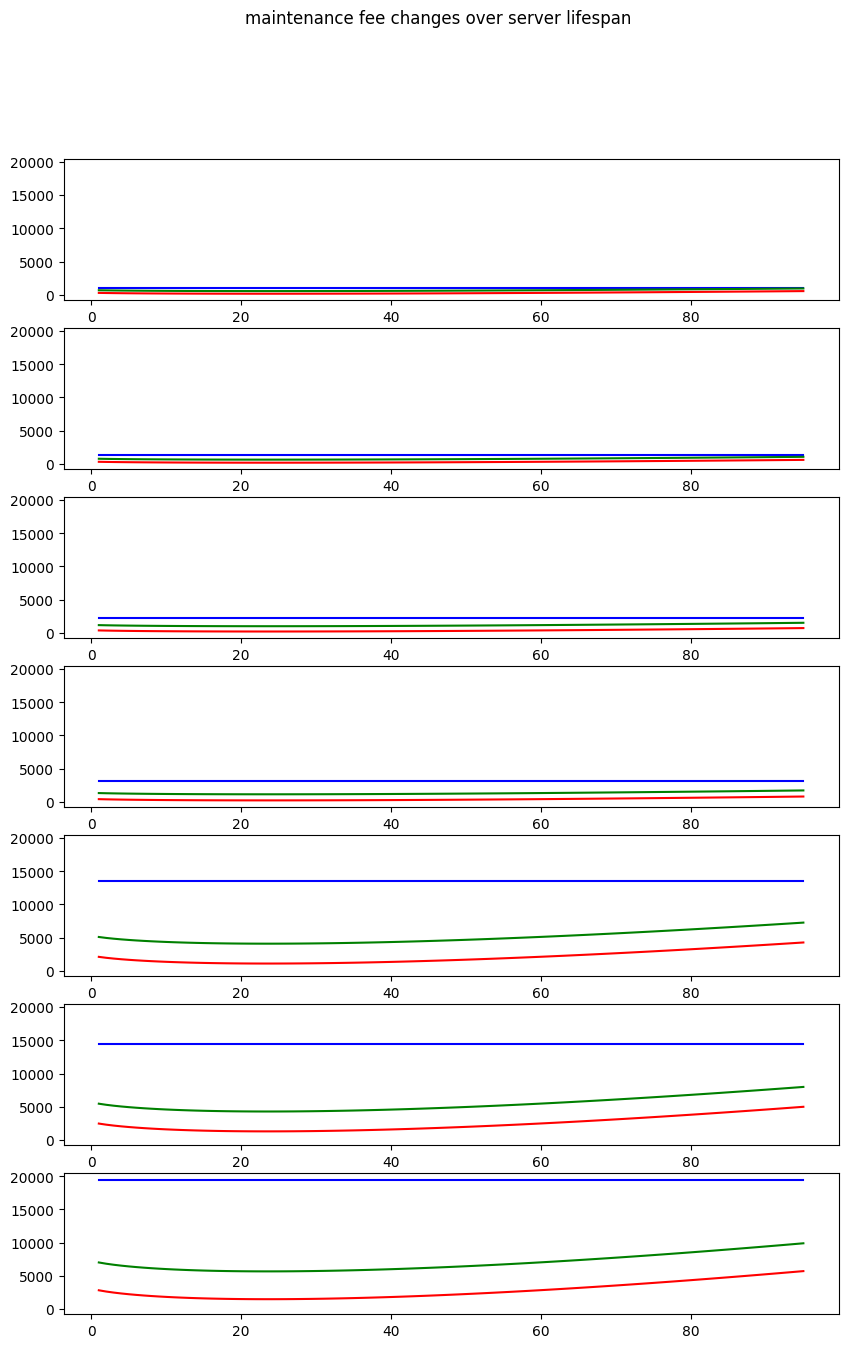

In [213]:
fig, axs = plt.subplots(7, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(10)
fig.suptitle("maintenance fee changes over server lifespan")
counter = 0
for i in servergen_maintenance_dict.keys():
    # if(counter > 3):
    #     counter += 1
    #     continue
    axs[counter].plot(np.arange(1,96,1), servergen_maintenance_dict[i], color="r")
    axs[counter].plot(np.arange(1,96,1), servergen_profit_dict[i], color="b")
    axs[counter].plot(np.arange(1,96,1), servergen_totalcost_dict[i], color="g")
    counter +=1

In [ ]:
#TLDR WILL ALWAYS GENERATE PROFIT NO MATTER HOW OLD SERVER GETS AND NO MATTER ENERGY PRICE only move action/having more
# than needed(server util is low) can make it generate negative profit

In [594]:
import numpy as np
from scipy.optimize import minimize

#for DC1 and servergen cpus1 over first TIMESTEPS timesteps

TIMESTEPS = 30

dc1_cap = datacenters[datacenters["datacenter_id"] == "DC1"]["slots_capacity"].iloc[0]
cpu_energies = servers["energy_consumption"].to_numpy()
purchase_prices = servers["purchase_price"].to_numpy()
capacity = servers["capacity"].to_numpy()

cpus1_energy= servers[servers["server_generation"] == "CPU.S1"]["energy_consumption"].iloc[0]
cpus1_purchasecost = servers[servers["server_generation"] == "CPU.S1"]["purchase_price"].iloc[0]
demand2 = demand[demand["latency_sensitivity"] == "low"]
demands = demand2.drop(columns=["latency_sensitivity","time_step"]).iloc[0:TIMESTEPS].to_numpy()
selling_prices_array = selling_prices[selling_prices["latency_sensitivity"] == "low"]["selling_price"].to_numpy()
maint_prices = servers["average_maintenance_fee"].to_numpy()

timestep_array = np.arange(1,96,1)
cpus1_maintenance_cost = servers[servers["server_generation"] == "CPU.S1"]["average_maintenance_fee"].iloc[0]
ts_array = 1.5 * timestep_array
maintenance_cost_array = np.empty((95,7))
for i in range(7):
    maintenance_cost_array[:,i] = (1+ ts_array/96 * np.log2(ts_array/96)) * maint_prices[i]
epsilon = 0.00000001

#where x is an array containing what servergen was bought at each timestep for all servergens
def capacity_constraint(x):
    x = np.reshape(x,(TIMESTEPS,7))
    total = 0
    #servernumber * slotsize to get slots occupied
    #for cpu
    occupied_slots = np.sum(x[:,0:4] * 2)
    #for gpu
    total = occupied_slots + np.sum(x[:,4:7] * 4)
    # #get total number of servers purchased
    # total = np.sum(x)
    # #servernumber * slotsize to get slots occupied
    # total = total * 2
    #constraint used cap has to be less than dc1_cap
    return dc1_cap - total

#get utilisation over the timesteps
def utilisation(x):
    util = np.zeros((TIMESTEPS))
    for i in range(7):
        servergen = x[:, i]
        #get cumulative sum of number of servers to get total owned at each timestep
        cumsum = np.cumsum(servergen)
        #get their capacity
        cumsum = cumsum * capacity[i]
        #get demand met for servergen i
        supply = np.minimum(cumsum, demands[:, i])
        cumsum = cumsum+epsilon
        #get fraction of servergen utilised at each timestep
        util = np.sum(util + np.divide(supply, cumsum))

    # ts1x = x[0]
    # ts2x = x[1]
    # ts1u = min(60*ts1x, 4000)/(60*ts1x+ epsilon)
    # ts2u = min(60*ts1x+60*ts2x, 8160)/(60*ts1x + 60*ts2x + epsilon)
    return util

def lifespan(x):
    #get number of servers bought for timesteps (servergen doesnt matter)
    ts_sum = np.sum(x, axis=1)
    cumsum = np.cumsum(ts_sum)+epsilon
    array = np.empty((TIMESTEPS))
    for i in range(1,TIMESTEPS+1):
        multiplication_arr = np.arange(i,0,-1)
        array[i-1] = np.divide(np.sum(np.multiply(ts_sum[0:i], multiplication_arr[0:i])), 96)

    life_span = np.divide(array, cumsum)

    # ts1x = x[0]
    # ts2x = x[1]
    # ts1ls = (ts1x/96) / (ts1x +epsilon)
    # ts2ls = ((ts1x)/48 + ts2x/96)/ (ts1x+ts2x+epsilon)

    return life_span

def profit(x):
    #get cumulative sum of number of servers for all servergens
    revenues = np.zeros((TIMESTEPS))
    for i in range(7):
        servergen = x[:, i]
        cumsum = np.cumsum(servergen)
        #get their capacity
        cumsum = cumsum* capacity[i]
        #get demand met
        supply = np.minimum(cumsum, demands[:,i])
        revenues = revenues + (supply * selling_prices_array[i])
    
    #calc energycost for all servergens at dc1
    energy_costs = cpu_energies * 0.25

    timestep_costs = np.empty((len(x)))
    for i in range(len(x)):
        #get servers that have been maintained (not new)
        maintained_servers = x[:i]
        #calc cost of new servers and add to overall cost at end
        new_cost = x[i] * (purchase_prices + energy_costs + maintenance_cost_array[i])
        new_cost = np.sum(new_cost)
        #calc energy + maintenance cost
        energy_and_maint = maintenance_cost_array[:i] + energy_costs
        #multiply corresponding servers with their cost to get total for servergen at each ts
        maint_cost = np.sum(np.multiply(maintained_servers, energy_and_maint[:i]))
        # if(maint_cost.size <= 0):
        #     maint_cost = np.zeros((7))
        timestep_costs[i] = maint_cost + new_cost
    print(timestep_costs)
    
    return revenues-timestep_costs

    # ts1x = x[0]
    # ts2x = x[1]
    # ts1revenue = min(60*ts1x, 4000) * 10
    # ts2revenue = min(60*ts1x+60*ts2x, 8160) * 10

    # maint_cost = maintenance_cost(x)
    # ts1cost = (1500 + energycost + maint_cost[0]) * ts1x
    # ts2cost = (energycost + maint_cost[1]) * ts1x + (energycost + maint_cost[0]) * ts2x

    # ts1p = ts1revenue-ts1cost
    # ts2p = ts2revenue-ts2cost
    # return [ts1p, ts2p]

def maintenance_cost(x):
    return maintenance_cost_array[0:len(x)]
    # ts1x = x[0]
    # ts2x = x[1]

    # ts1maintenance = (1+ 1.5/96 * np.log2(1.5/96)) * cpus1_maintenance_cost
    # ts2maintenance = (1+ 3/96 * np.log2(3/96)) * cpus1_maintenance_cost
    # return [ts1maintenance, ts2maintenance]


def objective_func(x):
    x = np.reshape(x,(TIMESTEPS, 7))
    U = utilisation(x)
    L = lifespan(x)
    P = profit(x)
    objectives = U * L * P
    Objective = np.sum(objectives)
    return Objective
    # ts1o = utilisation(x)[0] * lifespan(x)[0] * profit(x)[0]
    # ts2o = utilisation(x)[1] * lifespan(x)[1] * profit(x)[1]
    # O = ts1o + ts2o
    # return O

def negative_objective(x):
    return -1 * objective_func(x)

In [595]:
x0 = []
bounds = []
for i in range(TIMESTEPS*7):
    x0.append(2)
    if(i%5==0 or i%6==0 or i%7==0):
        if(i%6==0 or i%7==0):
            bounds.append((0, 0))
        else:
            bounds.append((0, int(dc1_cap/4)))
    else:
        if(i%2==0 or i%3==0):
            bounds.append((0, 0))
        else:
            bounds.append((0, int(dc1_cap/2)))

cons = ({'type': 'ineq', 'fun': capacity_constraint})

result = minimize(negative_objective, x0, method='SLSQP', bounds=bounds, constraints=cons)

[319172.9375     625042.375      711651.47806528 320578.97806528
 119310.87328987 694672.90817352 418322.22022792 665274.72022792
 402988.92133387 363011.85162598 446061.85600036 500265.78771703
 414196.39603442 671405.86486    480324.72525865 685104.72525865
 203514.00340641 492367.3670264  693696.29011076 750179.98727765
 480086.36728418 439512.5743377  562880.3798419  775292.11145439
 532599.16318022 750287.90137085 519208.24384764 836246.67698409
 526371.37967094 575240.72999078]
[319172.93774429 625042.37500587 711651.47807116 320578.97807116
 119310.87329574 694672.90817939 418322.22023379 665274.72023379
 402988.92133974 363011.85163186 446061.85600623 500265.7877229
 414196.3960403  671405.86486587 480324.72526453 685104.72526453
 203514.00341228 492367.36703227 693696.29011664 750179.98728353
 480086.36729005 439512.57434358 562880.37984777 775292.11146027
 532599.16318609 750287.90137673 519208.24385351 836246.67698996
 526371.37967681 575240.72999665]
[319172.93963373 625042

In [596]:
print("Optimization successful:", result.success)
print("Optimal values of servergen s1 to buy at dc1:")
for i in range(TIMESTEPS):
    print(f"at timestep {i}: {result.x[i]:.3f} number of servers")
print(f"Optimal objective value: {(-1* result.fun):.6f}")

Optimization successful: False
Optimal values of servergen s1 to buy at dc1:
at timestep 0: 0.000 number of servers
at timestep 1: 2.000 number of servers
at timestep 2: 0.000 number of servers
at timestep 3: 0.000 number of servers
at timestep 4: 0.000 number of servers
at timestep 5: 2.000 number of servers
at timestep 6: 0.000 number of servers
at timestep 7: 0.000 number of servers
at timestep 8: 0.000 number of servers
at timestep 9: 0.000 number of servers
at timestep 10: 2.000 number of servers
at timestep 11: 2.000 number of servers
at timestep 12: 0.000 number of servers
at timestep 13: 2.000 number of servers
at timestep 14: 0.000 number of servers
at timestep 15: 2.000 number of servers
at timestep 16: 0.000 number of servers
at timestep 17: 2.000 number of servers
at timestep 18: 0.000 number of servers
at timestep 19: 2.000 number of servers
at timestep 20: 2.000 number of servers
at timestep 21: 0.000 number of servers
at timestep 22: 0.000 number of servers
at timestep 2

In [583]:
print(f"{result.x}")

[0. 2. 0. 0. 0. 2. 0. 0. 0. 0. 2. 2. 0. 2. 0. 2. 0. 2. 0. 2. 2. 0. 0. 2.
 0. 2. 0. 0. 0. 2. 0. 2. 0. 0. 0. 0. 0. 2. 0. 0. 2. 2. 0. 2. 0. 2. 0. 2.
 0. 0. 2. 0. 0. 2. 0. 2. 0. 0. 0. 2. 0. 2. 0. 0. 0. 2. 0. 2. 0. 0. 0. 2.
 0. 2. 0. 2. 0. 0. 0. 2. 2. 0. 0. 2. 0. 2. 0. 0. 0. 2. 0. 0. 0. 0. 0. 2.
 0. 2. 0. 0. 2. 2. 0. 2. 0. 0. 0. 2. 0. 2. 2. 0. 0. 2. 0. 2. 0. 0. 0. 0.
 0. 2. 0. 0. 0. 2. 0. 2. 0. 0. 2. 2. 0. 0. 0. 2. 0. 2. 0. 2.]


In [407]:
a = [1,2,3,4,5]
abc = []
for i in range(1,len(a)+1):
    multiplication_arr = np.arange(i,0,-1)
    abc.append(np.multiply(a[0:i], multiplication_arr[0:i]))
print(abc)

[array([1]), array([2, 2]), array([3, 4, 3]), array([4, 6, 6, 4]), array([5, 8, 9, 8, 5])]


In [492]:
tt = np.arange(1,12,2)
tt = np.reshape(tt,(3,2))
print(tt)
print(tt +[3,10])

[[ 1  3]
 [ 5  7]
 [ 9 11]]
[[ 4 13]
 [ 8 17]
 [12 21]]
